# Finanzas Computacionales
## Proyecto grupal
### Profesor: Dr. Luis Vicente Montiel Cendejas
### Estudiante: Marina, Aldair y Eduardo
### Fecha de entrega: 23 de Mayo de 2022

# Resumen

Uno de los objetivos de este proyecto es ...

In [1]:
import numpy as np
import pandas as pd # librería para manejo de dataframes
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf # librería para descarga de históricos de Yahoo Finance
import math

from sklearn.model_selection import train_test_split


from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier


from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from sklearn import metrics

In [2]:
ticker = 'AAPL'
fecha_inicio = '2021-01-01'
fecha_fin = '2022-04-30'

In [3]:
def funcion_etiqueta(x):
    if x<=0:
        y = -1
    else:
        y = 1
    return(y)

def funcion_encoding(x):
    if x == -1:
        y = 0
    else:
        y = 1
    return(y)

In [4]:
###

In [5]:
def descarga_historico_full(ticker, fecha_inicio, fecha_fin):
    df_hist = yf.download(ticker, start = fecha_inicio, end = fecha_fin, progress =  False)
    df_hist = df_hist.iloc[1:][['High','Low','Close']]
    return(df_hist)

In [6]:
df_hist = descarga_historico_full(ticker, fecha_inicio, fecha_fin)

In [7]:
def genera_indicadores(df_hist):
    df = df_hist.iloc[1:][['High','Low','Close']]
    df['Prom_Movil'] = df['Close'].rolling(10).mean()
    ponder = np.arange(1,11)
    df['uma10'] = df['Close'].rolling(10).apply(lambda precios: np.dot(precios, ponder)/ponder.sum(), raw=True)
    df['Momentum'] = df['Close'] - df['Close'].shift(9)
    df['AD_oscilator'] = (df['High'] - df['Close'])/(df['High'] - df['Close'].shift(1))
    df['HighestHigh'] = df['High'].rolling(14).max()
    df['LowestLow'] = df['Low'].rolling(14).min()
    df['LarryWilliams'] = (df['HighestHigh']  - df['Close'])/(df['HighestHigh']  - df['LowestLow'])
    df['StochasticK'] = (df['Close'] - df['LowestLow'])/(df['HighestHigh']  - df['LowestLow'])
    df = df[['Prom_Movil','uma10','Momentum','AD_oscilator','LarryWilliams','StochasticK']]
    return(df)

In [8]:
genera_indicadores(df_hist)

,Prom_Movil,uma10,Momentum,AD_oscilator,LarryWilliams,StochasticK
Date,,,,,,
2021-01-06,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-07,NaN,NaN,NaN,0.141154,NaN,NaN
2021-01-08,NaN,NaN,NaN,0.339181,NaN,NaN
2021-01-11,NaN,NaN,NaN,-0.632978,NaN,NaN
2021-01-12,NaN,NaN,NaN,1.253508,NaN,NaN
...,...,...,...,...,...,...
2022-04-25,165.988998,165.273816,-2.869995,0.210139,0.777218,0.222782
2022-04-26,165.093999,163.603090,-10.860001,-10.259084,0.995269,0.004731
2022-04-27,163.984999,162.053273,-13.829987,1.076922,0.933815,0.066185


In [9]:
#####

In [10]:
def descarga_historico(ticker, fecha_inicio, fecha_fin):
    df_hist = yf.download(ticker, start = fecha_inicio, end = fecha_fin, progress=False)
    df = df_hist.iloc[1:]['Close']
    df = df.to_frame()
    return(df)

In [11]:
def construye_etiquetas(ticker, fecha_inicio, fecha_fin):
    df = descarga_historico(ticker, fecha_inicio, fecha_fin)
    df_diferencia = df['Close'] - df.shift(1)['Close']
    df_diferencia = df_diferencia.to_frame()
    df_diferencia['etiqueta'] = df_diferencia['Close'].apply(funcion_etiqueta)
    df_etiq = df_diferencia['etiqueta']
    df_etiq = df_etiq.to_frame()
    df_etiq['etiqueta_binaria'] = df_etiq['etiqueta'].apply(funcion_encoding)
    return(df_etiq)

In [12]:
df = construye_etiquetas(ticker, fecha_inicio, fecha_fin)
df

,etiqueta,etiqueta_binaria
Date,,
2021-01-05,1,1
2021-01-06,-1,0
2021-01-07,1,1
2021-01-08,1,1
2021-01-11,-1,0
...,...,...
2022-04-25,1,1
2022-04-26,-1,0
2022-04-27,-1,0


In [13]:
frecuencias = df['etiqueta'].value_counts()
frecuencias

 1    170
-1    163
Name: etiqueta, dtype: int64

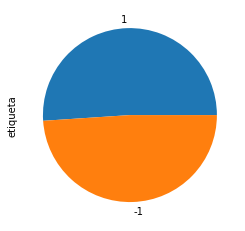

In [14]:
frecuencias.plot(kind='pie');

In [15]:
df_etiquetas = construye_etiquetas(ticker, fecha_inicio, fecha_fin)
df_indicadores = genera_indicadores(df_hist)

In [16]:
df_ml = pd.merge(df_etiquetas, df_indicadores, left_index=True, right_index=True)
df_ml = df_ml.dropna()

In [17]:
df_ml

,etiqueta,etiqueta_binaria,Prom_Movil,uma10,Momentum,AD_oscilator,LarryWilliams,StochasticK
Date,,,,,,,,
2021-01-26,1,1,133.762001,136.467819,14.360001,0.826084,0.103153,0.896847
2021-01-27,-1,0,135.088000,137.976546,11.169998,1.964918,0.166210,0.833790
2021-01-28,-1,0,135.708000,138.340545,8.179993,-70.008066,0.438837,0.561163
2021-01-29,-1,0,136.013000,137.659092,4.820007,-13.657497,0.720241,0.279759
2021-02-01,1,1,136.713000,137.318546,6.309998,0.362575,0.600658,0.399342
...,...,...,...,...,...,...,...,...
2022-04-25,1,1,165.988998,165.273816,-2.869995,0.210139,0.777218,0.222782
2022-04-26,-1,0,165.093999,163.603090,-10.860001,-10.259084,0.995269,0.004731
2022-04-27,-1,0,163.984999,162.053273,-13.829987,1.076922,0.933815,0.066185


In [18]:
# Regresión logística

feature_cols = ['Prom_Movil', 'uma10', 'Momentum']
X = df_ml[feature_cols] # Variables explicativas
y = df_ml['etiqueta_binaria'] # Variable respuesta

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[26, 11],
       [12, 31]])

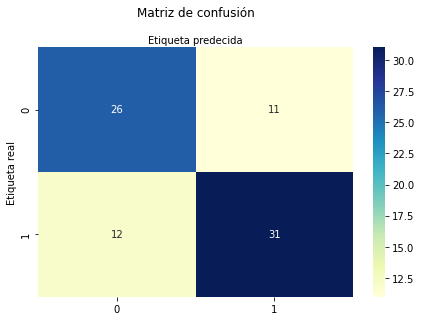

In [19]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matriz de confusión', y=1.1)
plt.ylabel('Etiqueta real')
plt.xlabel('Etiqueta predecida');

In [20]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precisión:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.7125
Precisión: 0.7380952380952381
Recall: 0.7209302325581395


In [21]:
## Máquina de soporte vectorial

feature_cols = ['Prom_Movil', 'uma10', 'Momentum']
X = df_ml[feature_cols] # Variables explicativas
y = df_ml['etiqueta'] # Variable respuesta -1/1

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

clf = svm.SVC(kernel='linear') # Kernel lineal
#### <--- Nos falta hacer la selección del kernel y los hiperparámetros
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[27, 10],
       [16, 27]])

In [22]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.675
Precision: 0.7297297297297297
Recall: 0.627906976744186


In [23]:
# Árbol de clasificación

clf_arbol = DecisionTreeClassifier()
## <--- Falta hacer la calibración de hiperparams: criterion="entropy", max_depth=3
clf_arbol = clf_arbol.fit(X_train,y_train)
y_pred = clf_arbol.predict(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[14, 23],
       [23, 20]])

In [24]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.425
Precision: 0.46511627906976744
Recall: 0.46511627906976744


In [25]:
# Random Forest

clf_rf = RandomForestClassifier(n_estimators=100)
clf_rf = clf_rf.fit(X_train,y_train)
y_pred = clf_rf.predict(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[13, 24],
       [24, 19]])

In [26]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.4
Precision: 0.4418604651162791
Recall: 0.4418604651162791


In [27]:
# Vecinos más cercanos

clf_kn = KNeighborsClassifier(n_neighbors=3)
clf_kn = clf_kn.fit(X_train,y_train)
y_pred = clf_kn.predict(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[19, 18],
       [20, 23]])

In [28]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.525
Precision: 0.5609756097560976
Recall: 0.5348837209302325


In [29]:
# AdaBoost

clf_ab = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
clf_ab = clf_ab.fit(X_train,y_train)
y_pred = clf_ab.predict(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[20, 17],
       [18, 25]])

In [30]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.5625
Precision: 0.5952380952380952
Recall: 0.5813953488372093
